In [36]:
import numpy as np 
import pandas as pd
from sklearn.cluster import KMeans
import csv
import math
import matplotlib.pyplot
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping, TensorBoard


maxAcc = 0.0
maxIter = 0
TrainingPercent = 90
ValidationPercent = 10
TestPercent = 10
PHI = []
IsConcat = True
IsConcat = True
humanDataSampleSize=791
gscDataSampleSize=50000
humanFeaturesFile='HumanObserved-Features-Data.csv'
humanSamePairFile='same_pairs.csv'
humanDiffPairFile='diffn_pairs.csv'
gscFeatureFile = 'GSC-Features.csv'
gscSamePairFile='same_pairs_gsc.csv'
gscDiffPairFile='diffn_pairs_gsc.csv'

In [37]:
def processData(data,samePair,diffPair,sampleSize,isGSC):
    
    if(isGSC == False):
        data = pd.read_csv(data,index_col=0)
    else:
        data = pd.read_csv(data)


    samePair = pd.read_csv(samePair)


    diffPair = pd.read_csv(diffPair)


    merged1 = pd.merge(samePair, data, left_on = ['img_id_A'],right_on= ['img_id'],how = 'inner').drop(['img_id'], axis='columns')
    merged2 = pd.merge(samePair, data, left_on = ['img_id_B'],right_on= ['img_id'],how = 'inner').drop(['img_id','img_id_A','img_id_B','target'], axis='columns')

    merged3=pd.concat([merged1, merged2],axis=1)


    merged4=merged1 - merged2
    merged4=merged4.drop(['img_id_A','img_id_B','target'], axis='columns')
    merged4=pd.concat([merged4,merged1['target']],axis=1)



    diffmerged1 =pd.merge(diffPair, data, left_on = ['img_id_A'],right_on= ['img_id'],how = 'inner').drop(['img_id'], axis='columns')
    diffmerged2 = pd.merge(diffPair, data, left_on = ['img_id_B'],right_on= ['img_id'],how = 'inner').drop(['img_id','img_id_A','img_id_B','target'], axis='columns')


    diffmerged3=pd.concat([diffmerged1, diffmerged2],axis=1).sample(n=sampleSize)


    diffmerged4=diffmerged1 - diffmerged2
    diffmerged4=diffmerged4.drop(['img_id_A','img_id_B','target'], axis='columns')
    diffmerged4=pd.concat([diffmerged4,diffmerged1['target']],axis=1)
    diffmerged5=diffmerged4.sample(n=sampleSize).abs()


    if(isGSC == True):
        merged3=merged3.sample(n=sampleSize)
        subtractionFeatures=merged4.sample(n=sampleSize).abs()
    else:
        merged3=merged3
        subtractionFeatures=merged4.abs()

    concatFeatures=merged3.append(diffmerged3)    
    concatFeatures=shuffle(concatFeatures)
    print("Feature Concatenation:"+str(concatFeatures.shape))
    subtractionFeatures=subtractionFeatures.append(diffmerged5)
    subtractionFeatures=shuffle(subtractionFeatures)
    print("Feature Subtraction:"+str(subtractionFeatures.shape))
    return concatFeatures,subtractionFeatures

In [64]:
def GetTargetVector(features):

    target=features['target'].values.T.tolist()

    return target


def GenerateRawData(features,isConcat):
    
    features = features.loc[:, (features != 0).any(axis=0)]#Removing features with all 0 values
    if(isConcat == True):
        dataMatrix = features.drop(columns=['img_id_A','img_id_B','target']).as_matrix()
    else:
        dataMatrix = features.drop(columns=['target']).as_matrix()
    dataMatrix = np.transpose(dataMatrix)
    #print (dataMatrix)

    return dataMatrix

def GenerateTrainingTarget(rawTraining,TrainingPercent = 90):
    TrainingLen = int(math.ceil(len(rawTraining)*(TrainingPercent*0.01)))
    t           = rawTraining[:TrainingLen]
    #print(str(TrainingPercent) + "% Training Target Generated..")
    return t


def GenerateTrainingDataMatrix(rawData, TrainingPercent = 90):
    T_len = int(math.ceil(len(rawData[0])*0.01*TrainingPercent))
    d2 = rawData[:,0:T_len]
    #print(str(TrainingPercent) + "% Training Data Generated..")
    return d2

def GenerateValData(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData[0])*ValPercent*0.01))
    V_End = TrainingCount + valSize
    dataMatrix = rawData[:,TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Data Generated..")  
    return dataMatrix

def GenerateValTargetVector(rawData, ValPercent, TrainingCount): 
    valSize = int(math.ceil(len(rawData)*ValPercent*0.01))
    #print(rawData)
    V_End = TrainingCount + valSize
    t =rawData[TrainingCount+1:V_End]
    #print (str(ValPercent) + "% Val Target Data Generated..")
    #print(t)
    return t

In [39]:
def generateFeatureData(isConcat,data,samePair,diffPair,sampleSize,isGSC):
    concatFeatures,subtractionFeatures = processData(data,samePair,diffPair,sampleSize,isGSC)
    return  concatFeatures,subtractionFeatures

def generateData(features,isConcat):
    RawTarget = GetTargetVector(features)
    RawData   = GenerateRawData(features,isConcat)

    
    
    
    return  RawTarget,RawData  

#Creating Training dataset
def createTrainingDataset(RawTarget,RawData):
    TrainingTarget = np.array(GenerateTrainingTarget(RawTarget,TrainingPercent))
    TrainingData   = GenerateTrainingDataMatrix(RawData,TrainingPercent)
    print("TrainingTarget Data: "+str(TrainingTarget.shape))
    print("Training Data: "+str(TrainingData.shape))
    return TrainingTarget,TrainingData

#Prepare Testing data
def createTestingDataset(RawTarget,RawData,TrainingTarget):
    
    TestDataAct = np.array(GenerateValTargetVector(RawTarget,TestPercent, (len(TrainingTarget))))
    TestData    = GenerateValData(RawData,TestPercent, (len(TrainingTarget)))
    print("TestingTarget Data: "+str(TestDataAct.shape))
    print("Testing Data: "+str(TestData.shape))
    return TestDataAct,TestData



In [40]:

def generateModel(RawData):
    
    input_size = RawData.shape[0]
    drop_out = 0.2
    first_dense_layer_nodes  = 512 # Increased number of dense layer nodes to 512
    second_dense_layer_nodes = 256
    #second1_dense_layer_nodes = 128
    third_dense_layer_nodes = 2


    model = Sequential()
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size, kernel_initializer='normal'))
    model.add(Activation('relu'))
    
    model.add(Dropout(drop_out))
    
    model.add(Dense(second_dense_layer_nodes, input_dim=input_size/2, kernel_initializer='normal'))
    model.add(Activation('relu'))



    model.add(Dropout(drop_out))

    model.add(Dense(third_dense_layer_nodes))
    model.add(Activation('softmax'))


    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model


In [41]:
def runModel(TrainingTarget,TrainingData,model):
    validation_data_split = 0.2 # This is the validation data split ratio from the training set .This means last 20% of
# data will be used as the validation set.
    num_epochs = 1000 
    
    model_batch_size = 256 # No of training examples used per iteration
    tb_batch_size = 32 # batch_size used in callback functions to get the statistics of the model that is getting trained
    early_patience = 300 # no of epochs with no improvement after which training is stopped

# EarlyStopping is used to stop the training when a monitored value stops improving.
    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

    TrainingData = np.transpose(TrainingData)
    TrainingTarget = np.transpose(TrainingTarget)
    TargetVector = np_utils.to_categorical(np.array(TrainingTarget))
#print(TrainingData)
    history = model.fit(TrainingData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )
    return history

In [42]:
#Feature Generation
concatFeatures,subtractionFeatures=generateFeatureData(IsConcat,humanFeaturesFile,humanSamePairFile
                                  ,humanDiffPairFile,humanDataSampleSize,False)
#Feature Concatenation
concatRawTarget,concatRawData = generateData(concatFeatures,IsConcat)
concatTrainingTarget,concatTrainingData=createTrainingDataset(concatRawTarget,concatRawData)
concatTestDataAct,concatTestData=createTestingDataset(concatRawTarget,concatRawData,concatTrainingTarget)



Feature Concatenation:(1582, 21)
Feature Subtraction:(1582, 10)
TrainingTarget Data: (1424,)
Training Data: (18, 1424)
TestingTarget Data: (157,)
Testing Data: (18, 157)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [43]:
concatModel=generateModel(concatRawData)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 512)               9728      
_________________________________________________________________
activation_13 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_14 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 514       
__________

In [44]:
concatHistory = runModel(concatTrainingTarget,concatTrainingData,concatModel)

Train on 1139 samples, validate on 285 samples
Epoch 1/1000
1139/1139 [==============================] - 1s 1ms/step - loss: 0.7376 - acc: 0.4943 - val_loss: 0.6863 - val_acc: 0.5439
Epoch 2/1000
1139/1139 [==============================] - 1s 666us/step - loss: 0.7021 - acc: 0.5373 - val_loss: 0.6860 - val_acc: 0.5544
Epoch 3/1000
1139/1139 [==============================] - 1s 646us/step - loss: 0.6892 - acc: 0.5505 - val_loss: 0.6952 - val_acc: 0.5404
Epoch 4/1000
1139/1139 [==============================] - 1s 650us/step - loss: 0.6799 - acc: 0.5716 - val_loss: 0.6953 - val_acc: 0.5719
Epoch 5/1000
1139/1139 [==============================] - 1s 724us/step - loss: 0.6761 - acc: 0.5821 - val_loss: 0.6919 - val_acc: 0.5649
Epoch 6/1000
1139/1139 [==============================] - 1s 960us/step - loss: 0.6703 - acc: 0.5716 - val_loss: 0.6879 - val_acc: 0.5719
Epoch 7/1000
1139/1139 [==============================] - 1s 657us/step - loss: 0.6704 - acc: 0.6014 - val_loss: 0.6886 - val_a

Epoch 60/1000
1139/1139 [==============================] - 1s 635us/step - loss: 0.3180 - acc: 0.8639 - val_loss: 0.8735 - val_acc: 0.6211
Epoch 61/1000
1139/1139 [==============================] - 1s 639us/step - loss: 0.3147 - acc: 0.8683 - val_loss: 0.8811 - val_acc: 0.5930
Epoch 62/1000
1139/1139 [==============================] - 1s 650us/step - loss: 0.3004 - acc: 0.8648 - val_loss: 0.8827 - val_acc: 0.6140
Epoch 63/1000
1139/1139 [==============================] - 1s 639us/step - loss: 0.3204 - acc: 0.8595 - val_loss: 0.8933 - val_acc: 0.6281
Epoch 64/1000
1139/1139 [==============================] - 1s 649us/step - loss: 0.3023 - acc: 0.8709 - val_loss: 0.8872 - val_acc: 0.6105
Epoch 65/1000
1139/1139 [==============================] - 1s 648us/step - loss: 0.2990 - acc: 0.8771 - val_loss: 0.8724 - val_acc: 0.6351
Epoch 66/1000
1139/1139 [==============================] - 1s 640us/step - loss: 0.3032 - acc: 0.8709 - val_loss: 0.8852 - val_acc: 0.6000
Epoch 67/1000
1139/1139 [==

Epoch 119/1000
1139/1139 [==============================] - 1s 642us/step - loss: 0.1437 - acc: 0.9517 - val_loss: 1.2569 - val_acc: 0.6246
Epoch 120/1000
1139/1139 [==============================] - 1s 685us/step - loss: 0.1473 - acc: 0.9394 - val_loss: 1.3118 - val_acc: 0.6175
Epoch 121/1000
1139/1139 [==============================] - 1s 650us/step - loss: 0.1449 - acc: 0.9482 - val_loss: 1.2565 - val_acc: 0.6351
Epoch 122/1000
1139/1139 [==============================] - 1s 642us/step - loss: 0.1392 - acc: 0.9596 - val_loss: 1.2596 - val_acc: 0.6211
Epoch 123/1000
1139/1139 [==============================] - 1s 643us/step - loss: 0.1471 - acc: 0.9517 - val_loss: 1.2622 - val_acc: 0.6281
Epoch 124/1000
1139/1139 [==============================] - 1s 638us/step - loss: 0.1310 - acc: 0.9579 - val_loss: 1.3068 - val_acc: 0.6070
Epoch 125/1000
1139/1139 [==============================] - 1s 642us/step - loss: 0.1395 - acc: 0.9500 - val_loss: 1.2792 - val_acc: 0.6316
Epoch 126/1000
1139/

1139/1139 [==============================] - 1s 744us/step - loss: 0.1009 - acc: 0.9701 - val_loss: 1.6045 - val_acc: 0.6456
Epoch 178/1000
1139/1139 [==============================] - 1s 729us/step - loss: 0.1028 - acc: 0.9631 - val_loss: 1.6476 - val_acc: 0.6070
Epoch 179/1000
1139/1139 [==============================] - 1s 639us/step - loss: 0.0953 - acc: 0.9710 - val_loss: 1.5147 - val_acc: 0.6456
Epoch 180/1000
1139/1139 [==============================] - 1s 632us/step - loss: 0.1001 - acc: 0.9728 - val_loss: 1.5438 - val_acc: 0.6070
Epoch 181/1000
1139/1139 [==============================] - 1s 639us/step - loss: 0.0879 - acc: 0.9737 - val_loss: 1.5226 - val_acc: 0.6421
Epoch 182/1000
1139/1139 [==============================] - 1s 626us/step - loss: 0.0817 - acc: 0.9710 - val_loss: 1.5304 - val_acc: 0.6175
Epoch 183/1000
1139/1139 [==============================] - 1s 638us/step - loss: 0.0803 - acc: 0.9754 - val_loss: 1.6105 - val_acc: 0.6175
Epoch 184/1000
1139/1139 [=========

1139/1139 [==============================] - 1s 659us/step - loss: 0.0502 - acc: 0.9842 - val_loss: 1.7872 - val_acc: 0.6351
Epoch 236/1000
1139/1139 [==============================] - 1s 654us/step - loss: 0.0539 - acc: 0.9851 - val_loss: 1.8268 - val_acc: 0.6351
Epoch 237/1000
1139/1139 [==============================] - 1s 641us/step - loss: 0.0630 - acc: 0.9860 - val_loss: 1.8250 - val_acc: 0.6175
Epoch 238/1000
1139/1139 [==============================] - 1s 645us/step - loss: 0.0492 - acc: 0.9895 - val_loss: 1.8069 - val_acc: 0.6316
Epoch 239/1000
1139/1139 [==============================] - 1s 641us/step - loss: 0.0430 - acc: 0.9903 - val_loss: 1.8603 - val_acc: 0.6281
Epoch 240/1000
1139/1139 [==============================] - 1s 648us/step - loss: 0.0480 - acc: 0.9842 - val_loss: 1.8467 - val_acc: 0.6351
Epoch 241/1000
1139/1139 [==============================] - 1s 653us/step - loss: 0.0544 - acc: 0.9851 - val_loss: 1.8222 - val_acc: 0.6175
Epoch 242/1000
1139/1139 [=========

1139/1139 [==============================] - 1s 664us/step - loss: 0.0458 - acc: 0.9851 - val_loss: 1.9302 - val_acc: 0.6386
Epoch 294/1000
1139/1139 [==============================] - 1s 655us/step - loss: 0.0454 - acc: 0.9886 - val_loss: 1.9913 - val_acc: 0.6316
Epoch 295/1000
1139/1139 [==============================] - 1s 642us/step - loss: 0.0420 - acc: 0.9903 - val_loss: 2.0176 - val_acc: 0.6105
Epoch 296/1000
1139/1139 [==============================] - 1s 656us/step - loss: 0.0375 - acc: 0.9903 - val_loss: 2.0498 - val_acc: 0.6105
Epoch 297/1000
1139/1139 [==============================] - 1s 655us/step - loss: 0.0506 - acc: 0.9816 - val_loss: 2.0537 - val_acc: 0.6246
Epoch 298/1000
1139/1139 [==============================] - 1s 654us/step - loss: 0.0530 - acc: 0.9868 - val_loss: 2.0367 - val_acc: 0.6421
Epoch 299/1000
1139/1139 [==============================] - 1s 640us/step - loss: 0.0585 - acc: 0.9816 - val_loss: 2.1153 - val_acc: 0.6211
Epoch 300/1000
1139/1139 [=========

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3b2c9a58>,
      dtype=object)

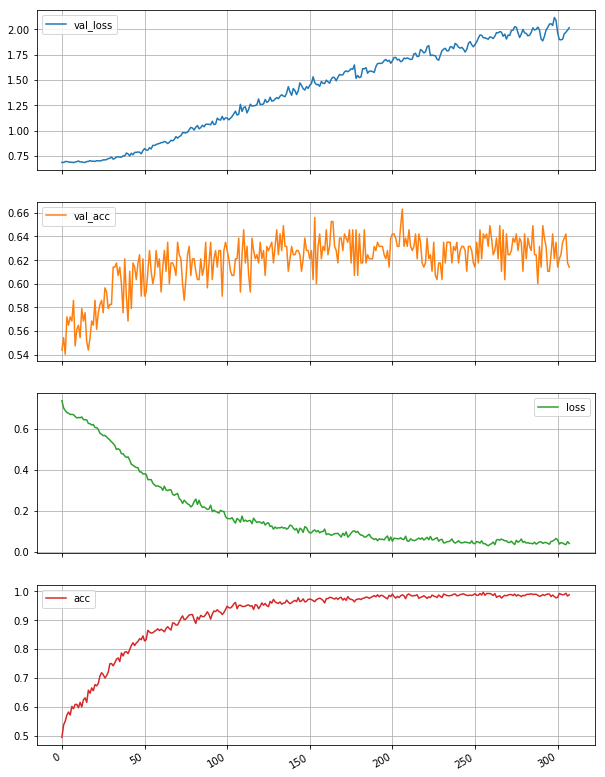

In [45]:
%matplotlib inline
df = pd.DataFrame(concatHistory.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [46]:
concatPredictedTestLabel = []
cWrong   = 0
cRight   = 0
concatTestData = np.transpose(concatTestData)
concatTestDataAct = np.transpose(concatTestDataAct)

concatPredictions = concatModel.predict(concatTestData)


for i in range (0,len(concatPredictions)):
    
    concatPredictedTestLabel.append(concatPredictions[i].argmax())
    if(concatPredictedTestLabel[i]==concatTestDataAct[i]):
        cRight = cRight + 1


cAccuracy = accuracy_score(concatTestDataAct, concatPredictedTestLabel)


print ('UBITname      = APURBAMA')
print ('Person Number = 50288705')
print ('----------------------------------------------------')
print ("------------------Human Feature Concatenation Data------------------------")
print ('------------------KERAS Neural Network Model----------------------')

print ("Correct Predictions  = " + str(cRight))
print ("Testing Accuracy  = " + str(cAccuracy* 100))




UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------Human Feature Concatenation Data------------------------
------------------KERAS Neural Network Model----------------------
Correct Predictions  = 98
Testing Accuracy  = 62.42038216560509


In [47]:
#Feature Subtraction
subRawTarget,subRawData = generateData(subtractionFeatures,False)
subTrainingTarget,subTrainingData=createTrainingDataset(subRawTarget,subRawData)
subTestDataAct,subTestData=createTestingDataset(subRawTarget,subRawData,subTrainingTarget)

TrainingTarget Data: (1424,)
Training Data: (9, 1424)
TestingTarget Data: (157,)
Testing Data: (9, 157)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [48]:
subModel=generateModel(subRawData)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 512)               5120      
_________________________________________________________________
activation_16 (Activation)   (None, 512)               0         
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 256)               131328    
_________________________________________________________________
activation_17 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_12 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 2)                 514       
__________

In [49]:
subHistory = runModel(subTrainingTarget,subTrainingData,subModel)

Train on 1139 samples, validate on 285 samples
Epoch 1/1000
1139/1139 [==============================] - 1s 1ms/step - loss: 0.7037 - acc: 0.4925 - val_loss: 0.6766 - val_acc: 0.5474
Epoch 2/1000
1139/1139 [==============================] - 1s 653us/step - loss: 0.6923 - acc: 0.5356 - val_loss: 0.7181 - val_acc: 0.4772
Epoch 3/1000
1139/1139 [==============================] - 1s 663us/step - loss: 0.6895 - acc: 0.5549 - val_loss: 0.6859 - val_acc: 0.5333
Epoch 4/1000
1139/1139 [==============================] - 1s 794us/step - loss: 0.6932 - acc: 0.5285 - val_loss: 0.6898 - val_acc: 0.5158
Epoch 5/1000
1139/1139 [==============================] - 1s 772us/step - loss: 0.6841 - acc: 0.5514 - val_loss: 0.7228 - val_acc: 0.4702
Epoch 6/1000
1139/1139 [==============================] - 1s 644us/step - loss: 0.6812 - acc: 0.5531 - val_loss: 0.6909 - val_acc: 0.5263
Epoch 7/1000
1139/1139 [==============================] - 1s 656us/step - loss: 0.6828 - acc: 0.5417 - val_loss: 0.6880 - val_a

Epoch 60/1000
1139/1139 [==============================] - 1s 668us/step - loss: 0.4699 - acc: 0.7805 - val_loss: 0.7997 - val_acc: 0.5965
Epoch 61/1000
1139/1139 [==============================] - 1s 964us/step - loss: 0.4775 - acc: 0.7726 - val_loss: 0.7666 - val_acc: 0.5825
Epoch 62/1000
1139/1139 [==============================] - 1s 640us/step - loss: 0.4785 - acc: 0.7735 - val_loss: 0.7676 - val_acc: 0.5754
Epoch 63/1000
1139/1139 [==============================] - 1s 640us/step - loss: 0.4503 - acc: 0.7849 - val_loss: 0.8266 - val_acc: 0.5684
Epoch 64/1000
1139/1139 [==============================] - 1s 674us/step - loss: 0.4536 - acc: 0.7919 - val_loss: 0.7684 - val_acc: 0.5965
Epoch 65/1000
1139/1139 [==============================] - 1s 969us/step - loss: 0.4516 - acc: 0.7989 - val_loss: 0.8197 - val_acc: 0.5860
Epoch 66/1000
1139/1139 [==============================] - 1s 726us/step - loss: 0.4508 - acc: 0.7893 - val_loss: 0.8215 - val_acc: 0.5895
Epoch 67/1000
1139/1139 [==

Epoch 119/1000
1139/1139 [==============================] - 1s 764us/step - loss: 0.3266 - acc: 0.8674 - val_loss: 0.9358 - val_acc: 0.6105
Epoch 120/1000
1139/1139 [==============================] - 1s 676us/step - loss: 0.3442 - acc: 0.8428 - val_loss: 0.9856 - val_acc: 0.5825
Epoch 121/1000
1139/1139 [==============================] - 1s 652us/step - loss: 0.3340 - acc: 0.8507 - val_loss: 0.9310 - val_acc: 0.6035
Epoch 122/1000
1139/1139 [==============================] - 1s 639us/step - loss: 0.3411 - acc: 0.8622 - val_loss: 0.9372 - val_acc: 0.6140
Epoch 123/1000
1139/1139 [==============================] - 1s 671us/step - loss: 0.3379 - acc: 0.8446 - val_loss: 0.9943 - val_acc: 0.5965
Epoch 124/1000
1139/1139 [==============================] - 1s 904us/step - loss: 0.3381 - acc: 0.8534 - val_loss: 0.9727 - val_acc: 0.6175
Epoch 125/1000
1139/1139 [==============================] - 1s 641us/step - loss: 0.3420 - acc: 0.8393 - val_loss: 1.0048 - val_acc: 0.5860
Epoch 126/1000
1139/

1139/1139 [==============================] - 1s 711us/step - loss: 0.2609 - acc: 0.8885 - val_loss: 1.1078 - val_acc: 0.6175
Epoch 178/1000
1139/1139 [==============================] - 1s 906us/step - loss: 0.2636 - acc: 0.8929 - val_loss: 1.0998 - val_acc: 0.6000
Epoch 179/1000
1139/1139 [==============================] - 1s 958us/step - loss: 0.2454 - acc: 0.9017 - val_loss: 1.1588 - val_acc: 0.6035
Epoch 180/1000
1139/1139 [==============================] - 1s 723us/step - loss: 0.2744 - acc: 0.8850 - val_loss: 1.0965 - val_acc: 0.6000
Epoch 181/1000
1139/1139 [==============================] - 1s 660us/step - loss: 0.2626 - acc: 0.8885 - val_loss: 1.1519 - val_acc: 0.5930
Epoch 182/1000
1139/1139 [==============================] - 1s 640us/step - loss: 0.2459 - acc: 0.9061 - val_loss: 1.0766 - val_acc: 0.6140
Epoch 183/1000
1139/1139 [==============================] - 1s 634us/step - loss: 0.2536 - acc: 0.8982 - val_loss: 1.1160 - val_acc: 0.6000
Epoch 184/1000
1139/1139 [=========

1139/1139 [==============================] - 1s 653us/step - loss: 0.2200 - acc: 0.9166 - val_loss: 1.2380 - val_acc: 0.6035
Epoch 236/1000
1139/1139 [==============================] - 1s 634us/step - loss: 0.2076 - acc: 0.9140 - val_loss: 1.2513 - val_acc: 0.5965
Epoch 237/1000
1139/1139 [==============================] - 1s 627us/step - loss: 0.2266 - acc: 0.9052 - val_loss: 1.2933 - val_acc: 0.6035
Epoch 238/1000
1139/1139 [==============================] - 1s 648us/step - loss: 0.2024 - acc: 0.9245 - val_loss: 1.2564 - val_acc: 0.5965
Epoch 239/1000
1139/1139 [==============================] - 1s 621us/step - loss: 0.1912 - acc: 0.9350 - val_loss: 1.3125 - val_acc: 0.5965
Epoch 240/1000
1139/1139 [==============================] - 1s 693us/step - loss: 0.2017 - acc: 0.9210 - val_loss: 1.3309 - val_acc: 0.5965
Epoch 241/1000
1139/1139 [==============================] - 1s 670us/step - loss: 0.1921 - acc: 0.9333 - val_loss: 1.2975 - val_acc: 0.6035
Epoch 242/1000
1139/1139 [=========

1139/1139 [==============================] - 1s 662us/step - loss: 0.1775 - acc: 0.9236 - val_loss: 1.3610 - val_acc: 0.6000
Epoch 294/1000
1139/1139 [==============================] - 1s 682us/step - loss: 0.1868 - acc: 0.9254 - val_loss: 1.4397 - val_acc: 0.5860
Epoch 295/1000
1139/1139 [==============================] - 1s 665us/step - loss: 0.1720 - acc: 0.9271 - val_loss: 1.3816 - val_acc: 0.6035
Epoch 296/1000
1139/1139 [==============================] - 1s 833us/step - loss: 0.1658 - acc: 0.9456 - val_loss: 1.3749 - val_acc: 0.5860
Epoch 297/1000
1139/1139 [==============================] - 1s 804us/step - loss: 0.1660 - acc: 0.9412 - val_loss: 1.3555 - val_acc: 0.5789
Epoch 298/1000
1139/1139 [==============================] - 1s 633us/step - loss: 0.1552 - acc: 0.9447 - val_loss: 1.4004 - val_acc: 0.6000
Epoch 299/1000
1139/1139 [==============================] - 1s 748us/step - loss: 0.1807 - acc: 0.9271 - val_loss: 1.4265 - val_acc: 0.6000
Epoch 300/1000
1139/1139 [=========

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3bb97748>,
      dtype=object)

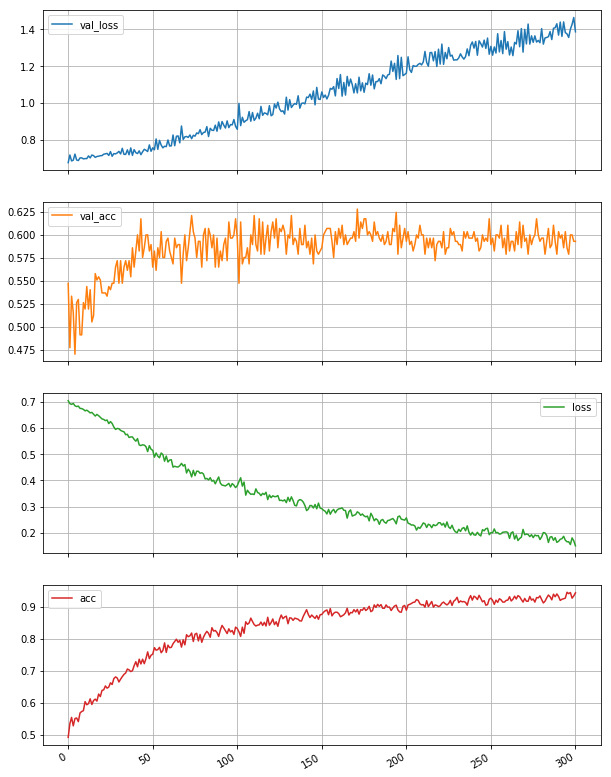

In [50]:
%matplotlib inline
df = pd.DataFrame(subHistory.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [51]:
subPredictedTestLabel = []
sWrong   = 0
sRight   = 0
subTestData = np.transpose(subTestData)
subTestDataAct = np.transpose(subTestDataAct)

subPredictions = subModel.predict(subTestData)


for i in range (0,len(subPredictions)):
    
    subPredictedTestLabel.append(subPredictions[i].argmax())
    if(subPredictedTestLabel[i]==subTestDataAct[i]):
        sRight = sRight + 1


sAccuracy = accuracy_score(subTestDataAct, subPredictedTestLabel)


print ('UBITname      = APURBAMA')
print ('Person Number = 50288705')
print ('----------------------------------------------------')
print ("------------------Human Feature Subtraction Data------------------------")
print ('------------------KERAS Neural Network Model----------------------')

print ("Correct Predictions  = " + str(sRight))
print ("Testing Accuracy  = " + str(sAccuracy* 100))

UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------Human Feature Subtraction Data------------------------
------------------KERAS Neural Network Model----------------------
Correct Predictions  = 101
Testing Accuracy  = 64.3312101910828


In [52]:
def genGSCModel(RawData):
    input_size = RawData.shape[0]
    drop_out = 0.1
    first_dense_layer_nodes  = 100 # Increased number of dense layer nodes to 512
    second_dense_layer_nodes = 256
    second1_dense_layer_nodes = 128
    third_dense_layer_nodes = 2


    model = Sequential()
    model.add(Dense(first_dense_layer_nodes, input_dim=input_size))
    model.add(Activation('relu'))



    #model.add(Dense(second1_dense_layer_nodes, input_dim=input_size))
    #model.add(Activation('relu'))

    model.add(Dropout(drop_out))

    model.add(Dense(third_dense_layer_nodes))
    model.add(Activation('softmax'))


    model.compile(optimizer='sgd',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.summary()
    return model

In [57]:
def runGSCModel(TrainingData,TrainingTarget,model):
    
    validation_data_split = 0.2 # This is the validation data split ratio from the training set .This means last 20% of
# data will be used as the validation set.
    num_epochs = 60 # epochs are the number of datasets given to the model to learn.Changing to 1000 for 3 dense layers
# as accuracy is reaching 0.99 in the first 200 epochs only   
    model_batch_size = 128 # No of training examples used per iteration
    tb_batch_size = 32 # batch_size used in callback functions to get the statistics of the model that is getting trained
    early_patience = 50 # no of epochs with no improvement after which training is stopped

# EarlyStopping is used to stop the training when a monitored value stops improving.
    tensorboard_cb   = TensorBoard(log_dir='logs', batch_size= tb_batch_size, write_graph= True)
    earlystopping_cb = EarlyStopping(monitor='val_loss', verbose=1, patience=early_patience, mode='min')

    TrainingData = np.transpose(TrainingData)
    TrainingTarget = np.transpose(TrainingTarget)
    TargetVector = np_utils.to_categorical(np.array(TrainingTarget))
    #print(TrainingData)
    history = model.fit(TrainingData
                    , TargetVector
                    , validation_split=validation_data_split
                    , epochs=num_epochs
                    , batch_size=model_batch_size
                    , callbacks = [tensorboard_cb,earlystopping_cb]
                   )
    return history

In [54]:
#GSC Feature Generation
gscConcatFeatures,gscSubtractionFeatures=generateFeatureData(IsConcat,gscFeatureFile,gscSamePairFile
                                  ,gscDiffPairFile,gscDataSampleSize,True)
#GSC Feature Concatenation
gscConcatRawTarget,gscConcatRawData = generateData(gscConcatFeatures,IsConcat)
gscConcatTrainingTarget,gscConcatTrainingData=createTrainingDataset(gscConcatRawTarget,gscConcatRawData)
gscConcatTestDataAct,gscConcatTestData=createTestingDataset(gscConcatRawTarget,gscConcatRawData,gscConcatTrainingTarget)


Feature Concatenation:(100000, 1027)
Feature Subtraction:(100000, 513)
TrainingTarget Data: (90000,)
Training Data: (1017, 90000)
TestingTarget Data: (9999,)
Testing Data: (1017, 9999)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  if sys.path[0] == '':


In [55]:
gscConcatModel=genGSCModel(gscConcatRawData)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 100)               101800    
_________________________________________________________________
activation_19 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_20 (Activation)   (None, 2)                 0         
Total params: 102,002
Trainable params: 102,002
Non-trainable params: 0
_________________________________________________________________


In [59]:
gscConcatHistory = runGSCModel(gscConcatTrainingData,gscConcatTrainingTarget,gscConcatModel)

Train on 72000 samples, validate on 18000 samples
Epoch 1/60
72000/72000 [==============================] - 28s 389us/step - loss: 0.6851 - acc: 0.5596 - val_loss: 0.6546 - val_acc: 0.6139
Epoch 2/60
72000/72000 [==============================] - 32s 450us/step - loss: 0.6340 - acc: 0.6418 - val_loss: 0.6018 - val_acc: 0.6869
Epoch 3/60
72000/72000 [==============================] - 32s 444us/step - loss: 0.5751 - acc: 0.7059 - val_loss: 0.5428 - val_acc: 0.7406
Epoch 4/60
72000/72000 [==============================] - 26s 364us/step - loss: 0.5218 - acc: 0.7469 - val_loss: 0.4954 - val_acc: 0.7696
Epoch 5/60
72000/72000 [==============================] - 29s 398us/step - loss: 0.4857 - acc: 0.7695 - val_loss: 0.4642 - val_acc: 0.7863
Epoch 6/60
72000/72000 [==============================] - 27s 372us/step - loss: 0.4578 - acc: 0.7863 - val_loss: 0.4383 - val_acc: 0.8019
Epoch 7/60
72000/72000 [==============================] - 26s 357us/step - loss: 0.4341 - acc: 0.8000 - val_loss: 0.

72000/72000 [==============================] - 28s 384us/step - loss: 0.0746 - acc: 0.9791 - val_loss: 0.0985 - val_acc: 0.9736
Epoch 60/60
72000/72000 [==============================] - 27s 373us/step - loss: 0.0733 - acc: 0.9798 - val_loss: 0.0981 - val_acc: 0.9726


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a3c572cc0>,
      dtype=object)

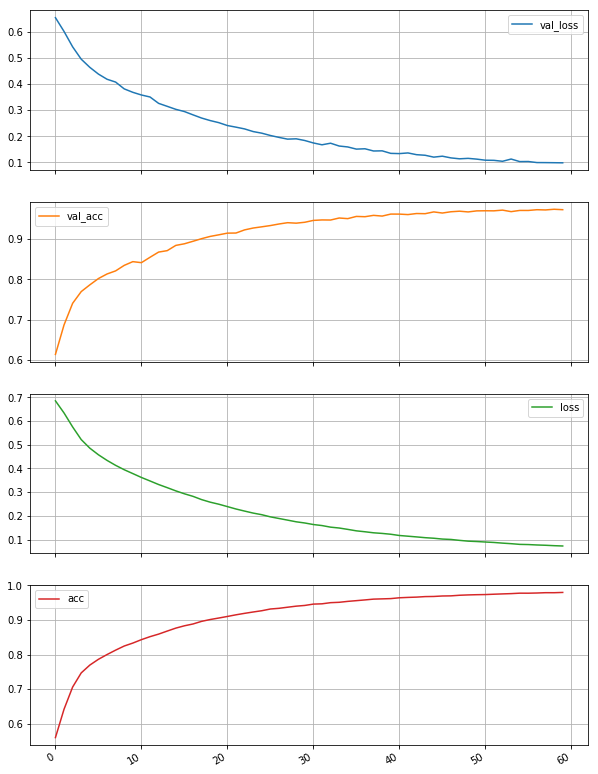

In [60]:
%matplotlib inline
df = pd.DataFrame(gscConcatHistory.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [61]:
gscConcatPredictedTestLabel = []
gscConcatWrong   = 0
gscConcatRight   = 0
gscConcatTestData = np.transpose(gscConcatTestData)
gscConcatTestDataAct = np.transpose(gscConcatTestDataAct)

gscConcatPredictions = gscConcatModel.predict(gscConcatTestData)


for i in range (0,len(gscConcatPredictions)):
    
    gscConcatPredictedTestLabel.append(gscConcatPredictions[i].argmax())
    if(gscConcatPredictedTestLabel[i]==gscConcatTestDataAct[i]):
        gscConcatRight = gscConcatRight + 1


gscConcatAccuracy = accuracy_score(gscConcatTestDataAct, gscConcatPredictedTestLabel)


print ('UBITname      = APURBAMA')
print ('Person Number = 50288705')
print ('----------------------------------------------------')
print ("------------------GSC Feature Concatenation Data------------------------")
print ('------------------KERAS Neural Network Model----------------------')

print ("Correct Predictions  = " + str(gscConcatRight))
print ("Testing Accuracy  = " + str(gscConcatAccuracy * 100))

UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------GSC Feature Concatenation Data------------------------
------------------KERAS Neural Network Model----------------------
Correct Predictions  = 9754
Testing Accuracy  = 97.54975497549755


In [65]:

#GSC Feature Subtraction
gscsubRawTarget,gscsubRawData = generateData(gscSubtractionFeatures,False)
gscsubTrainingTarget,gscsubTrainingData=createTrainingDataset(gscsubRawTarget,gscsubRawData)
gscsubTestDataAct,gscsubTestData=createTestingDataset(gscsubRawTarget,gscsubRawData,gscsubTrainingTarget)


TrainingTarget Data: (90000,)
Training Data: (509, 90000)
TestingTarget Data: (9999,)
Testing Data: (509, 9999)


/anaconda3/envs/ML_Tensor_Keras/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [66]:
gscSubModel=genGSCModel(gscsubRawData)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 100)               51000     
_________________________________________________________________
activation_21 (Activation)   (None, 100)               0         
_________________________________________________________________
dropout_14 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_22 (Dense)             (None, 2)                 202       
_________________________________________________________________
activation_22 (Activation)   (None, 2)                 0         
Total params: 51,202
Trainable params: 51,202
Non-trainable params: 0
_________________________________________________________________


In [67]:
gscSubHistory = runGSCModel(gscsubTrainingData,gscsubTrainingTarget,gscSubModel)

Train on 72000 samples, validate on 18000 samples
Epoch 1/60
72000/72000 [==============================] - 17s 233us/step - loss: 0.6203 - acc: 0.6511 - val_loss: 0.5481 - val_acc: 0.7329
Epoch 2/60
72000/72000 [==============================] - 14s 199us/step - loss: 0.5264 - acc: 0.7457 - val_loss: 0.4988 - val_acc: 0.7630
Epoch 3/60
72000/72000 [==============================] - 15s 202us/step - loss: 0.4899 - acc: 0.7686 - val_loss: 0.4733 - val_acc: 0.7798
Epoch 4/60
72000/72000 [==============================] - 14s 199us/step - loss: 0.4670 - acc: 0.7836 - val_loss: 0.4558 - val_acc: 0.7896
Epoch 5/60
72000/72000 [==============================] - 15s 203us/step - loss: 0.4515 - acc: 0.7925 - val_loss: 0.4429 - val_acc: 0.7970
Epoch 6/60
72000/72000 [==============================] - 14s 201us/step - loss: 0.4385 - acc: 0.8010 - val_loss: 0.4323 - val_acc: 0.8007
Epoch 7/60
72000/72000 [==============================] - 14s 200us/step - loss: 0.4277 - acc: 0.8063 - val_loss: 0.

72000/72000 [==============================] - 16s 218us/step - loss: 0.1806 - acc: 0.9355 - val_loss: 0.2195 - val_acc: 0.9200
Epoch 60/60
72000/72000 [==============================] - 15s 205us/step - loss: 0.1777 - acc: 0.9367 - val_loss: 0.2177 - val_acc: 0.9234


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1a42f3bf98>,
      dtype=object)

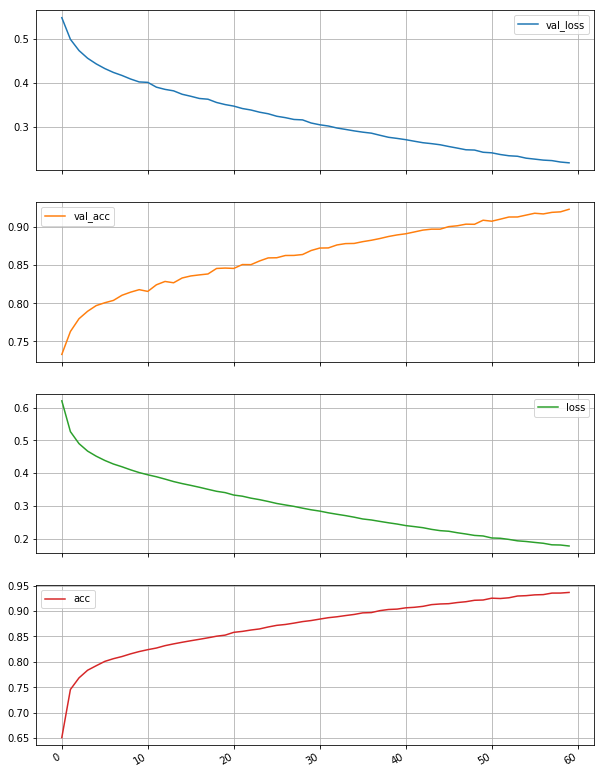

In [68]:
%matplotlib inline
df = pd.DataFrame(gscSubHistory.history)
df.plot(subplots=True, grid=True, figsize=(10,15))

In [71]:
gscsubPredictedTestLabel = []
gscsubWrong   = 0
gscsubRight   = 0
gscsubTestData = np.transpose(gscsubTestData)
gscsubTestDataAct = np.transpose(gscsubTestDataAct)

gscsubPredictions = gscSubModel.predict(gscsubTestData)


for i in range (0,len(gscsubPredictions)):
    
    gscsubPredictedTestLabel.append(gscsubPredictions[i].argmax())
    if(gscsubPredictedTestLabel[i]==gscsubTestDataAct[i]):
        gscsubRight = gscsubRight + 1


gscsubAccuracy = accuracy_score(gscsubTestDataAct, gscsubPredictedTestLabel)


print ('UBITname      = APURBAMA')
print ('Person Number = 50288705')
print ('----------------------------------------------------')
print ("------------------GSC Feature Subtraction Data------------------------")
print ('------------------KERAS Neural Network Model----------------------')

print ("Correct Predictions  = " + str(gscsubRight))
print ("Testing Accuracy  = " + str(gscsubAccuracy * 100))

UBITname      = APURBAMA
Person Number = 50288705
----------------------------------------------------
------------------GSC Feature Subtraction Data------------------------
------------------KERAS Neural Network Model----------------------
Correct Predictions  = 9211
Testing Accuracy  = 92.11921192119212
